In [11]:
# load necessary libraries. install what you don't have
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
import time
#import io # new and important wow
#import keras ## new. install tensorflow?
#import argparse


In [12]:
## Testing out the MET Museum API

In [13]:
'''
EDA Questions to explore:

What is the frequency of European Artwork across the 1970-1990s period? 
If one decade dominates in terms of amount of pieces maybe we need to ensure
that we sample 1000 images from each decade for a more uniform sample

What is the frequency of drawings to photographs during the time period?
If there is an imbalance maybe we need to sample a set amount of each.

What is the average pixel dimensions of the images, based on this we have
justification for making each photo the same pixel size

How many NAs (year)


'''

'\nEDA Questions to explore:\n\nWhat is the frequency of European Artwork across the 1970-1990s period? \nIf one decade dominates in terms of amount of pieces maybe we need to ensure\nthat we sample 1000 images from each decade for a more uniform sample\n\nWhat is the frequency of drawings to photographs during the time period?\nIf there is an imbalance maybe we need to sample a set amount of each.\n\nWhat is the average pixel dimensions of the images, based on this we have\njustification for making each photo the same pixel size\n\nHow many NAs (year)\n\n\n'

In [14]:
def get_image_data(a, b): #input is in department number and department name
    url_test = "https://collectionapi.metmuseum.org/public/collection/v1"
    departments = ("/search?departmentId=" + str(a) +"&hasImages=true&dateBegin=1800&dateEnd=2000&q=" + b)
    response = requests.get(url_test+departments)
    if response.status_code == 200 :
        print("API request successful!")
        data = response.json()
    else:
        print("Failed to retrieve data: {response.status_code}")

    print("Total Items Retrieved From " + b + " department: " + str(data['total']))
    
    img_url = []
    date_list = []
    ID_list = data['objectIDs']
    
    index_val = 0 # if the distribution of years is wonky might want to consider random selection?
    counter_val = 0

    while counter_val <200: #set sample size
        object_id = ID_list[index_val]

        url_object = "https://collectionapi.metmuseum.org/public/collection/v1/objects/" 

        reponse_object = requests.get(url_object+str(object_id))

        if reponse_object.status_code == 200 :
            data_ob = reponse_object.json()

            image_url = data_ob['primaryImage']
            if image_url != "":
                img_url.append(image_url)
                date_val=data_ob['objectBeginDate']
                date_list.append(date_val)
            
                index_val+= 1
                counter_val+= 1
            else:
                index_val+=1
                counter_val=counter_val
            
            
            
            #conditional statement 

            #img_rep = requests.get(image_url).content
            #img = plt.imread(io.BytesIO(img_rep), format='JPG')
            #plt.imshow(img)

        # and this can be read directly as a np array i g? 
        else:
            print("Failed to retrieve url")
            index_val+= 1
            counter_val= counter_val 
            

        
        time.sleep(0.05)
    df = {'Year': date_list,
        'URL': img_url}
    df = pd.DataFrame(df)   
    df['Type'] = b
    return df
  

In [15]:
# code to show an image/process image characteristics.
'''
img_rep = requests.get(image_url).content
    img = plt.imread(io.BytesIO(img_rep), format='JPG')
    plt.imshow(img)
'''
# right now it is set to get 20 samples which is going to take 
# a few minutes in the first run. ideally we push to about 500? 
dr_url_list = get_image_data(9,"drawing")
pt_url_list = get_image_data(11,"painting")

print(len(dr_url_list), len(pt_url_list))


API request successful!
Total Items Retrieved From drawing department: 13438
Failed to retrieve url
Failed to retrieve url
Failed to retrieve url
Failed to retrieve url
Failed to retrieve url
API request successful!
Total Items Retrieved From painting department: 1014
Failed to retrieve url
200 200


In [16]:
pt_url_list.head()

,Year,URL,Type
0,1866,https://images.metmuseum.org/CRDImages/ep/orig...,painting
1,1804,https://images.metmuseum.org/CRDImages/ep/orig...,painting
2,1804,https://images.metmuseum.org/CRDImages/ep/orig...,painting
3,1846,https://images.metmuseum.org/CRDImages/ep/orig...,painting
4,1810,https://images.metmuseum.org/CRDImages/ep/orig...,painting


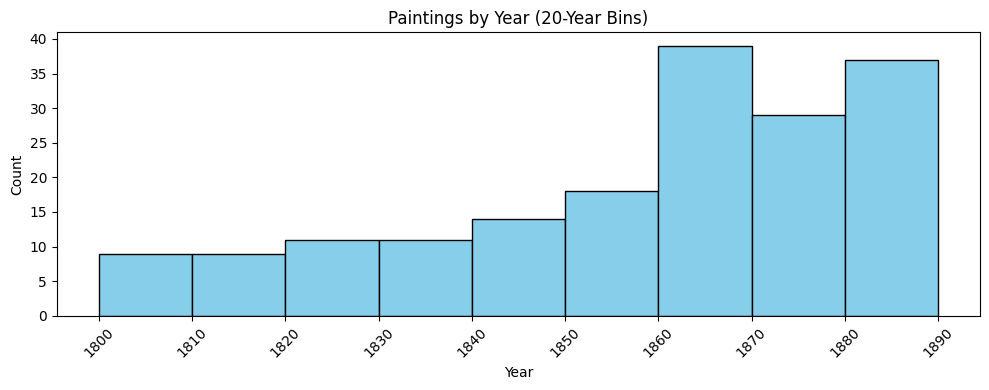

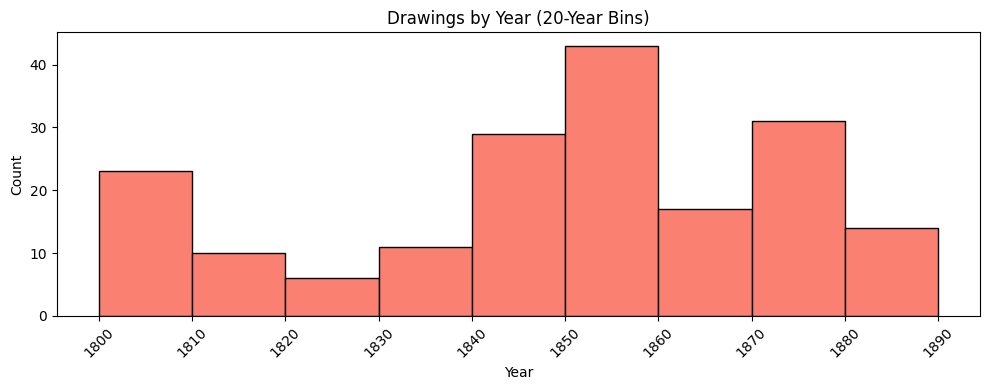

In [24]:
# Ensure Year is numeric
pt_url_list['Year'] = pd.to_numeric(pt_url_list['Year'], errors='coerce')
dr_url_list['Year'] = pd.to_numeric(dr_url_list['Year'], errors='coerce')
pt_years = pt_url_list['Year']
dr_years = dr_url_list['Year']

bins = range(1800, 1900, 10)

# Plot paintings histogram
plt.figure(figsize=(10, 4))
plt.hist(pt_years, bins=bins, color='skyblue', edgecolor='black')
plt.title('Paintings by Year (20-Year Bins)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(bins, rotation=45)
plt.tight_layout()
plt.show()

# Plot drawings histogram
plt.figure(figsize=(10, 4))
plt.hist(dr_years, bins=bins, color='salmon', edgecolor='black')
plt.title('Drawings by Year (20-Year Bins)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(bins, rotation=45)
plt.tight_layout()
plt.show()

In [25]:
from PIL import Image
from io import BytesIO
from tqdm import tqdm

def get_width(img):
    if img is not None:
        return img.width
    return None

def get_height(img):
    if img is not None:
        return img.height
    return None


def fetch_image_dimensions(df):
    widths = []
    heights = []

    for url in tqdm(df['URL'], desc="Fetching image dimensions"):
        time.sleep(0.05)
        try:
            response = requests.get(url, timeout=5)
            img = Image.open(BytesIO(response.content))
            widths.append(img.width)
            heights.append(img.height)
        except Exception as e:
            print(f"Failed to fetch {url}: {e}")
            widths.append(None)
            heights.append(None)
    
    df = df.copy()
    df['width'] = widths
    df['height'] = heights
    return df

pt_sample = pt_url_list.head(10)
dr_sample = dr_url_list.head(10)

pt_sample = fetch_image_dimensions(pt_sample)
dr_sample = fetch_image_dimensions(dr_sample)

avg_pt_width = pt_sample['width'].dropna().mean()
avg_pt_height = pt_sample['height'].dropna().mean()
avg_dr_width = dr_sample['width'].dropna().mean()
avg_dr_height = dr_sample['height'].dropna().mean()

print(f"Average Painting Size (10 samples): {avg_pt_width:.1f} x {avg_pt_height:.1f} pixels")
print(f"Average Drawing Size (10 samples): {avg_dr_width:.1f} x {avg_dr_height:.1f} pixels")


Fetching image dimensions: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]

Average Painting Size (10 samples): 2873.3 x 3670.7 pixels
Average Drawing Size (10 samples): 2718.1 x 3005.4 pixels


In [27]:
pt_sample.head()
dr_sample.head()

,Year,URL,Type,width,height
0,1865,https://images.metmuseum.org/CRDImages/dp/orig...,drawing,3342,2327
1,1880,https://images.metmuseum.org/CRDImages/dp/orig...,drawing,3629,2518
2,1911,https://images.metmuseum.org/CRDImages/dp/orig...,drawing,3770,2844
3,1878,https://images.metmuseum.org/CRDImages/dp/orig...,drawing,1397,3970
4,1878,https://images.metmuseum.org/CRDImages/dp/orig...,drawing,2487,2718
